In [ ]:
!pip install jax jaxlib
!pip install --quiet --upgrade scipy
!pip install --quiet jax jaxlib optax

In [3]:
import jax
from jax.scipy.stats import norm
import jax.numpy as jnp
from scipy.stats import norm
import time
from numpy.polynomial.legendre import leggauss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, brentq, minimize
from scipy.special import gamma
from numpy.polynomial.legendre import leggauss
import warnings
warnings.filterwarnings('ignore')
from math import log
from numpy.random import default_rng, SeedSequence
from scipy.stats import kstwobign, cramervonmises, uniform
from joblib import Parallel, delayed
from itertools import zip_longest
from collections import OrderedDict
import logging
logging.getLogger("matplotlib.backends.backend_ps").setLevel(logging.ERROR)


# ==============================================================
# ETELN ARE Table for same J
# ==============================================================


Table: ARE values for ETELN(α=2.0, β=0.5, θ=1.0)
       0.3    0.5    0.8    1.0    1.3    2.0    5.0    7.0    9.0    10.0
0.3   0.267  0.559  0.953  0.949  0.789  0.433  0.044  0.075  0.001  0.000
0.5   0.255  0.535  0.951  0.982  0.862  0.534  0.088  0.037  0.020  0.019
0.8   0.237  0.500  0.930  0.999  0.927  0.648  0.166  0.087  0.052  0.042
1.0   0.227  0.478  0.910  0.998  0.951  0.704  0.218  0.126  0.082  0.068
1.2   0.218  0.458  0.887  0.989  0.965  0.748  0.268  0.167  0.114  0.097
2.0   0.187  0.391  0.793  0.927  0.961  0.841  0.429  0.314  0.245  0.221
4.0   0.141  0.286  0.606  0.751  0.839  0.841  0.613  0.520  0.456  0.431
5.0   0.126  0.253  0.539  0.679  0.776  0.806  0.641  0.563  0.507  0.485
7.0   0.105  0.206  0.441  0.568  0.667  0.727  0.647  0.593  0.553  0.536
10.0  0.085  0.162  0.345  0.453  0.547  0.623  0.610  0.580  0.555  0.544

⚠️  Near-zero ARE values found at:
    (a,b) = (0.3, 9.0): ARE = 0.001086
    (a,b) = (0.3, 10.0): ARE = 0.000446

⭐ Maximum

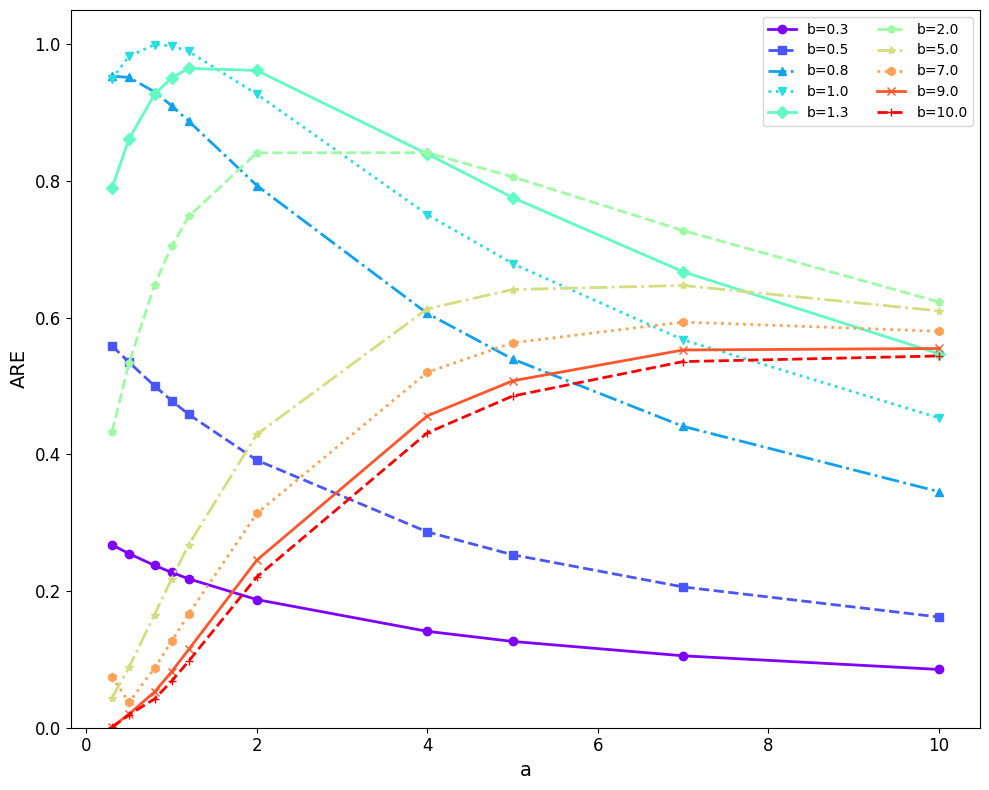


⏱️ Total runtime: 37.96 s


In [4]:
# ==============================================================
# ETELN ARE Table
# ==============================================================

# ---------- pretty, wide table printing ----------
pd.set_option("display.width", 2000)
pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)


class ETELNARE:
    def __init__(self, theta=1.0, kuma_a=1.0, kuma_b=1.0, n_quad=200):
        self.theta = theta
        self.kuma_a = kuma_a
        self.kuma_b = kuma_b
        self.n_quad = n_quad
        # Precompute Gauss–Legendre nodes & weights
        self.nodes, self.weights = np.polynomial.legendre.leggauss(n_quad)
        # Transform nodes from [-1,1] → [0,1]
        self.u = 0.5 * (self.nodes + 1)
        self.w = 0.5 * self.weights

    def kumaraswamy_weight(self, u, a=None, b=None):
        if a is None: a = self.kuma_a
        if b is None: b = self.kuma_b
        return a * b * (u ** (a - 1)) * ((1 - u**a) ** (b - 1))

    # ---- Dk integral using Gauss–Legendre ----
    def compute_dk(self, beta, k):
        """
        Compute d_{h,k}(β) = ∫₀¹ J(u) [Φ⁻¹[(2^β-(2^β-1)u)^(-1/β)]]^k du
        """
        u, w = self.u, self.w
        weights = self.kumaraswamy_weight(u)

        # u_0(β) = [2^β - (2^β-1)u]^(-1/β)
        base = 2**beta - (2**beta - 1) * u

        # Ensure base > 0 and compute u0
        mask = base > 0
        u0 = np.zeros_like(u)
        u0[mask] = base[mask] ** (-1/beta)

        # Clip u0 to valid probability range [ε, 1-ε]
        eps = 1e-9
        u0 = np.clip(u0, eps, 1 - eps)

        # ξ = Φ⁻¹[u₀(β)]
        xi = norm.ppf(u0)

        # Integrand: J(u) * ξ^k
        integrand = weights * (xi ** k)

        return np.sum(w * integrand)

    def tau(self, beta):
        """τ_h(β) = d_{h,2}(β) - [d_{h,1}(β)]²"""
        D1 = self.compute_dk(beta, 1)
        D2 = self.compute_dk(beta, 2)
        return D2 - D1**2

    def solve_beta(self, mu1, mu2, beta_range=(-3, 3)):
        """
        Solve implicit equation for β, then compute α
        For ETELN: μ₁ = log(θ) + (1/α)d_{h,1}
        So: d_{h,1}/α = μ₁ - log(θ)

        Implicit equation: d_{h,1}/√τ_h = (μ₁ - log θ)/√Δ_h
        """
        Delta = mu2 - mu1**2

        if Delta <= 0:
            print(f"  Warning: Delta <= 0 ({Delta:.6f})")
            return np.nan, np.nan

        def f(beta):
            try:
                D1 = self.compute_dk(beta, 1)
                t = self.tau(beta)

                if t <= 0:
                    return np.nan

                # R(β) = d_{h,1}/√τ_h - (μ₁ - log θ)/√Δ_h
                # Note: For ETELN, it's (μ₁ - log θ) not (log θ - μ₁)
                lhs = D1 / np.sqrt(t)
                rhs = (mu1 - np.log(self.theta)) / np.sqrt(Delta)

                return lhs - rhs
            except:
                return np.nan

        # Try to find sign change
        beta_test = np.linspace(beta_range[0], beta_range[1], 20)
        f_vals = [f(b) for b in beta_test]
        f_vals = np.array([v if not np.isnan(v) else 0 for v in f_vals])

        # Check for sign change
        sign_changes = np.where(np.diff(np.sign(f_vals)))[0]

        if len(sign_changes) == 0:
            return np.nan, np.nan

        # Use first sign change
        idx = sign_changes[0]
        beta_low = beta_test[idx]
        beta_high = beta_test[idx + 1]

        from scipy.optimize import brentq
        try:
            beta_hat = brentq(f, beta_low, beta_high, xtol=1e-10, rtol=1e-8, maxiter=500)
            t = self.tau(beta_hat)
            alpha_hat = np.sqrt(t / Delta)
            return alpha_hat, beta_hat
        except Exception as e:
            print(f"  Brentq failed: {e}")
            return np.nan, np.nan

    # ---- Variance–covariance matrix via Λ integrals ----
    def compute_lambda_integral(self, type_num, alpha, beta):
        """
        Compute Λ_{h,i} integrals for ETELN
        These involve 1/φ(ξ) terms
        """
        u, w = self.u, self.w
        weights = self.kumaraswamy_weight(u)

        # u_0(β) = [2^β - (2^β-1)u]^(-1/β)
        base = 2**beta - (2**beta - 1) * u
        mask = base > 0
        u0 = np.zeros_like(u)
        u0[mask] = base[mask] ** (-1/beta)

        # Clip to valid range
        eps = 1e-9
        u0 = np.clip(u0, eps, 1 - eps)

        # ξ = Φ⁻¹[u₀(β)]
        xi = norm.ppf(u0)

        # φ(ξ) = standard normal pdf
        phi_xi = norm.pdf(xi)

        # g(u) = [2^β-(2^β-1)u]^(-(1+β)/β) / φ(ξ)
        exponent = -(1 + beta) / beta
        g = np.zeros_like(u)
        valid_mask = (base > 0) & (phi_xi > 1e-300)
        g[valid_mask] = (base[valid_mask] ** exponent) / phi_xi[valid_mask]

        # kernel K(v,w) = min(v,w) - v*w
        def kernel(v, w):
            return np.minimum(v, w) - v * w

        result = 0.0
        for i in range(len(u)):
            for j in range(len(u)):
                if type_num == 1:
                    # Λ_{h,1}: g_i * g_j
                    val = weights[i] * weights[j] * kernel(u[i], u[j]) * g[i] * g[j]
                elif type_num == 2:
                    # Λ_{h,2}: g_i * ξ_j * g_j
                    val = weights[i] * weights[j] * kernel(u[i], u[j]) * g[i] * xi[j] * g[j]
                elif type_num == 3:
                    # Λ_{h,3}: ξ_i * g_i * ξ_j * g_j
                    val = weights[i] * weights[j] * kernel(u[i], u[j]) * xi[i] * g[i] * xi[j] * g[j]
                else:
                    raise ValueError("Invalid type_num")
                result += w[i] * w[j] * val

        return result

    def compute_variance_covariance(self, alpha, beta):
        """
        Compute Σ_L for ETELN (Different h, Same J)
        """
        delta = ((2**beta - 1) / (alpha * beta)) ** 2

        L1 = self.compute_lambda_integral(1, alpha, beta)
        L2 = self.compute_lambda_integral(2, alpha, beta)
        L3 = self.compute_lambda_integral(3, alpha, beta)

        # PLUS signs in off-diagonal (different from ETELL)
        Sigma11 = delta * L1
        Sigma12 = delta * (2*np.log(self.theta)*L1 + 2/alpha*L2)
        Sigma22 = delta * (4*np.log(self.theta)**2*L1 + 8*np.log(self.theta)/alpha*L2 + 4/alpha**2*L3)

        return np.array([[Sigma11, Sigma12], [Sigma12, Sigma22]])

    def fisher_information(self, alpha, beta, n):
        """
        Compute Fisher Information for ETELN
        """
        # Integration over u ∈ [0,1]
        u_int = np.linspace(1e-6, 1 - 1e-6, 64)

        # u_0(β) = [2^β - (2^β-1)u]^(-1/β)
        u0 = (2**beta - (2**beta - 1) * u_int) ** (-1/beta)
        u0 = np.clip(u0, 1e-9, 1 - 1e-9)

        # ξ = Φ⁻¹[u₀]
        xi = norm.ppf(u0)
        phi_xi = norm.pdf(xi)
        Phi_xi = norm.cdf(xi)

        # Avoid division by zero
        ratio = np.where(Phi_xi > 1e-300, phi_xi / Phi_xi, 0.0)
        ratio2 = np.where(Phi_xi > 1e-300, (phi_xi / Phi_xi) ** 2, 0.0)

        # Expectations
        moment2 = np.trapz(xi**2, u_int) / alpha**2
        moment_ratio1 = np.trapz(ratio * xi, u_int) / alpha
        moment_ratio3 = np.trapz(xi**3 * ratio, u_int) / alpha**2
        moment_ratio2_sq = np.trapz(xi**2 * ratio2, u_int) / alpha**2

        # Fisher Information elements
        two_pow_beta = 2**beta
        denom = two_pow_beta - 1

        # I_ββ (same as ETELL)
        Ibb = (1 / beta**2) * (1 - (two_pow_beta * beta**2 * (np.log(2)**2)) / (denom**2))

        # I_αα
        Iaa = (1 / alpha**2) * (1 + moment2 + (beta + 1)**2 * moment_ratio2_sq +
                                 2 * alpha * (beta + 1) * moment_ratio3)

        # I_αβ
        Iab = moment_ratio1

        return n * np.array([[Iaa, Iab], [Iab, Ibb]])

    # ---- ARE ----
    def compute_ARE(self, mu1, mu2, n):
        """Compute ARE for ETELN L-estimator vs MLE"""
        alpha_hat, beta_hat = self.solve_beta(mu1, mu2)

        if np.isnan(alpha_hat) or np.isnan(beta_hat):
            return np.nan

        Sigma = self.compute_variance_covariance(alpha_hat, beta_hat) / n

        # Jacobian (finite differences)
        eps = 1e-6
        def get_params(m1, m2):
            a, b = self.solve_beta(m1, m2)
            if np.isnan(a) or np.isnan(b):
                return alpha_hat, beta_hat
            return a, b

        alpha_p1, beta_p1 = get_params(mu1 + eps, mu2)
        alpha_m1, beta_m1 = get_params(mu1 - eps, mu2)
        alpha_p2, beta_p2 = get_params(mu1, mu2 + eps)
        alpha_m2, beta_m2 = get_params(mu1, mu2 - eps)

        D = np.array([
            [(alpha_p1 - alpha_m1) / (2*eps), (alpha_p2 - alpha_m2) / (2*eps)],
            [(beta_p1 - beta_m1) / (2*eps), (beta_p2 - beta_m2) / (2*eps)]
        ])

        S_K = D @ Sigma @ D.T
        I = self.fisher_information(alpha_hat, beta_hat, n)

        try:
            S_MLE = np.linalg.inv(I)
        except np.linalg.LinAlgError:
            return np.nan

        det_S_K = np.linalg.det(S_K)
        det_S_MLE = np.linalg.det(S_MLE)

        if det_S_K > 0 and det_S_MLE > 0:
            ARE_det = np.sqrt(det_S_MLE / det_S_K)
        else:
            ARE_det = np.nan

        return ARE_det


# ==============================================================
# Generate Table
# ==============================================================

def generate_eteln_are_table_and_plot(alpha_true=2.0, beta_true=0.5, n=1000):
    """
    Generate ARE table and interaction plot for ETELN distribution
    """
    a_values = [0.3, 0.5, 0.8, 1.0, 1.2, 2.0, 4.0, 5.0, 7.0, 10.0]
    b_values = [0.3, 0.5, 0.8, 1.0, 1.3, 2.0, 5.0, 7.0, 9.0, 10.0]

    are_matrix = np.zeros((len(a_values), len(b_values)))

    for i, a in enumerate(a_values):

        for j, b in enumerate(b_values):
            solver = ETELNARE(theta=1.0, kuma_a=a, kuma_b=b, n_quad=200)

            # Compute population moments using ETELN quantile function
            u, w = solver.u, solver.w

            # Q(u) = θ exp{(1/α) Φ⁻¹[(2^β-(2^β-1)u)^(-1/β)]}
            base = 2**beta_true - (2**beta_true - 1) * u
            u0 = base ** (-1/beta_true)
            u0 = np.clip(u0, 1e-9, 1 - 1e-9)
            xi = norm.ppf(u0)

            q = solver.theta * np.exp((1/alpha_true) * xi)

            # Weighted moments
            weights_J = solver.kumaraswamy_weight(u, a, b)
            mu1 = np.sum(w * weights_J * np.log(q))
            mu2 = np.sum(w * weights_J * (np.log(q) ** 2))

            are_matrix[i, j] = solver.compute_ARE(mu1, mu2, n)

    df = pd.DataFrame(are_matrix, index=a_values, columns=b_values)
    print("\n" + "="*80)
    print(f"Table: ARE values for ETELN(α={alpha_true}, β={beta_true}, θ=1.0)")
    print("="*80)
    print(df.round(3))

    # Find problematic values
    near_zero = (are_matrix < 0.01) & (are_matrix > 0)
    if np.any(near_zero):
        print("\n⚠️  Near-zero ARE values found at:")
        for i, j in zip(*np.where(near_zero)):
            print(f"    (a,b) = ({a_values[i]}, {b_values[j]}): ARE = {are_matrix[i,j]:.6f}")

    # ---- Find max ARE -------
    valid_mask = ~np.isnan(are_matrix)
    if np.any(valid_mask):
        max_are = np.nanmax(are_matrix)
        max_idx = np.unravel_index(np.nanargmax(are_matrix), are_matrix.shape)
        optimal_a = a_values[max_idx[0]]
        optimal_b = b_values[max_idx[1]]
        print(f"\n⭐ Maximum ARE = {max_are:.3f} at a={optimal_a}, b={optimal_b}")
    else:
        print("\n⚠️ All ARE values are NaN!")
        return df, are_matrix

    # ---- Plot interaction figure ----
    fig, ax = plt.subplots(figsize=(10, 8))

    colors = plt.cm.rainbow(np.linspace(0, 1, len(b_values)))
    linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--']
    markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', 'x', '+']

    for j, b in enumerate(b_values):
        ax.plot(a_values, are_matrix[:, j],
                linestyle=linestyles[j],
                marker=markers[j],
                markersize=6,
                linewidth=2,
                color=colors[j],
                label=f"b={b}")

    ax.set_xlabel("a", fontsize=14)
    ax.set_ylabel("ARE", fontsize=14)
    #ax.set_title(f"ARE for ETELN(α={alpha_true}, β={beta_true}): Different h, Same J",
    #             fontsize=12)
    ax.set_ylim(0, 1.05)
    ax.grid(False)
    ax.legend(loc="best", ncol=2, fontsize=10)
    ax.tick_params(labelsize=12)

    plt.tight_layout()
    plt.savefig("eteln_are_interaction.pdf", dpi=300, bbox_inches='tight')
    plt.savefig("eteln_are_interaction.png", dpi=300, bbox_inches='tight')
    plt.savefig("eteln_are_interaction.eps", dpi=300, bbox_inches='tight')
    plt.show()

    return df, are_matrix


# ==============================================================
# Run
# ==============================================================

if __name__ == "__main__":
    t0 = time.perf_counter()
    df, mat = generate_eteln_are_table_and_plot(alpha_true=2.0, beta_true=0.5)
    print(f"\n⏱️ Total runtime: {time.perf_counter() - t0:.2f} s")

# ==============================================================
# ETELN ARE Table for different J
# ==============================================================

Computing ARE values for ETELN Design B...
Fixed: J₁(1.0, 1.0), varying J₂(a, b)

Table: ARE values for ETELN(α=2.0, β=0.5) - Design B
      0.6   0.7   0.8   1.0   7.0   8.0   9.0   10.0  11.0  12.0
0.3  0.656 0.522 0.085 0.774 0.262 0.225 0.196 0.172 0.153 0.137
0.5  0.721 0.717 0.422 0.819 0.405 0.366 0.334 0.307 0.284 0.265
0.8  0.777 0.845 0.863 0.868 0.567 0.531 0.499 0.473 0.449 0.428
1.0  0.799 0.882 0.937     — 0.650 0.615 0.585 0.560 0.537 0.517
1.2  0.814 0.903 0.964 0.912 0.716 0.684 0.656 0.632 0.610 0.591
2.0  0.843 0.935 0.989 0.960 0.872 0.851 0.831 0.814 0.798 0.783
4.0  0.847 0.936 0.986 0.997 0.825 0.844 0.856 0.863 0.867 0.869
5.0  0.840 0.928 0.979 0.999 0.662 0.706 0.738 0.761 0.778 0.792
7.0  0.822 0.909 0.960 0.994 0.263 0.340 0.400 0.448 0.488 0.520
10.0 0.795 0.879 0.932 0.976 0.186 0.112 0.049 0.005 0.064 0.093

⭐ Maximum ARE = 0.999
   at J₁(1.0,1.0) × J₂(5.0,1.0)

⚠️  Near-zero values (< 0.01): 1
   • J₂(10.0,10.0): 0.004660


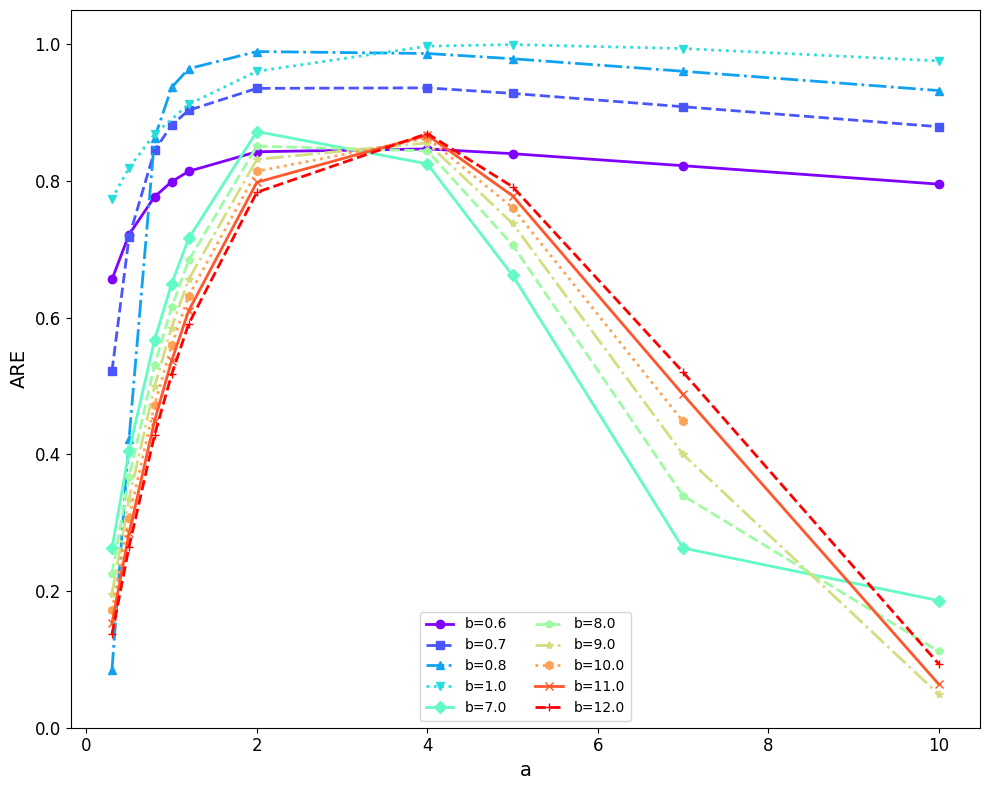


⏱️ Total runtime: 100.05 s


In [6]:
# ==============================================================
# ETELN ARE - Different J (J₁ ≠ J₂), Same h = log(x)
# ==============================================================

pd.set_option("display.width", 2000)
pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)

warnings.filterwarnings('ignore')


class ETELNARE_DesignB:
    """Design B: Different J (J₁ ≠ J₂), Same h(x) = log(x)"""

    def __init__(self, theta=1.0, kuma_a1=1.0, kuma_b1=1.0,
                 kuma_a2=1.0, kuma_b2=1.0, n_quad=250):
        self.theta = theta
        self.kuma_a1 = kuma_a1
        self.kuma_b1 = kuma_b1
        self.kuma_a2 = kuma_a2
        self.kuma_b2 = kuma_b2
        self.n_quad = n_quad

        nodes, weights = np.polynomial.legendre.leggauss(n_quad)
        self.u = 0.5 * (nodes + 1)
        self.w = 0.5 * weights

    def kumaraswamy_pdf(self, u, a, b):
        """Kumaraswamy PDF with numerical stability"""
        with np.errstate(all='ignore'):
            if a > 20 or b > 20:
                result = a * b * np.exp((a-1)*np.log(u) + (b-1)*np.log(1 - u**a))
            else:
                result = a * b * (u ** (a - 1)) * ((1 - u**a) ** (b - 1))
            return np.nan_to_num(result, nan=0.0, posinf=0.0, neginf=0.0)

    def J1(self, u):
        return self.kumaraswamy_pdf(u, self.kuma_a1, self.kuma_b1)

    def J2(self, u):
        return self.kumaraswamy_pdf(u, self.kuma_a2, self.kuma_b2)

    def compute_dw_k(self, beta, k):
        """
        Compute d_{w,k}(β) = ∫₀¹ J_k(u) [Φ⁻¹[(2^β-(2^β-1)u)^(-1/β)]] du
        """
        u, w = self.u, self.w
        weights = self.J1(u) if k == 1 else self.J2(u)

        with np.errstate(all='ignore'):
            base = 2**beta - (2**beta - 1) * u
            base = np.maximum(base, 1e-15)

            u0 = base ** (-1/beta)
            u0 = np.clip(u0, 1e-9, 1 - 1e-9)

            xi = norm.ppf(u0)
            xi = np.where(np.isfinite(xi), xi, 0.0)

            integrand = weights * xi

        return np.sum(w * integrand)

    def tau_w(self, beta):
        """τ_w(β) = d_{w,2}(β) - d_{w,1}(β)"""
        return self.compute_dw_k(beta, 2) - self.compute_dw_k(beta, 1)

    def solve_beta_robust(self, mu1, mu2):
        """
        Ultra-robust β solver for ETELN
        Implicit equation: d_{w,1}/τ_w - (μ₁ - log θ)/Δ_w = 0
        Note: POSITIVE ratio for α = τ_w/Δ_w (different from ETELL!)
        """
        Delta_w = mu2 - mu1

        if abs(Delta_w) < 1e-12:
            return np.nan, np.nan

        def Psi(beta):
            try:
                with np.errstate(all='ignore'):
                    d1 = self.compute_dw_k(beta, 1)
                    tau = self.tau_w(beta)

                    if not np.isfinite(d1) or not np.isfinite(tau):
                        return np.nan

                    if abs(tau) < 1e-12:
                        return 1e10 * np.sign(tau + 1e-15)

                    # For ETELN: (μ₁ - log θ) not (log θ - μ₁)
                    result = (d1 / tau) - (mu1 - np.log(self.theta)) / Delta_w
                    return result if np.isfinite(result) else np.nan
            except:
                return np.nan

        # Try multiple strategies
        strategies = [
            (1e-3, 3.0, 150),   # search β > 0 first
            (1e-3, 5.0, 250),   # wider positive range if needed
            (-3.0, -1e-3, 150), # only then allow negative β as fallback (if you ever want it)
        ]
        for beta_min, beta_max, n_points in strategies:
            try:
                beta_grid = np.linspace(beta_min, beta_max, n_points)
                psi_vals = np.array([Psi(b) for b in beta_grid])

                valid = np.isfinite(psi_vals)
                if np.sum(valid) < 3:
                    continue

                psi_valid = psi_vals[valid]
                beta_valid = beta_grid[valid]

                signs = np.sign(psi_valid)
                sign_changes = np.where(np.diff(signs) != 0)[0]

                if len(sign_changes) == 0:
                    continue

                for idx in sign_changes:
                    a, b = beta_valid[idx], beta_valid[idx + 1]

                    fa, fb = Psi(a), Psi(b)
                    if not (np.isfinite(fa) and np.isfinite(fb)):
                        continue

                    if fa * fb < 0:
                        try:
                            beta_hat = brentq(Psi, a, b, xtol=1e-11, rtol=1e-9, maxiter=500)
                            tau = self.tau_w(beta_hat)
                            # POSITIVE ratio for ETELN (not negative like ETELL!)
                            alpha_hat = tau / Delta_w

                            # Validation: require same-sign for positivity
                            if (alpha_hat > 0.01 and alpha_hat < 100 and
                                np.isfinite(alpha_hat) and abs(beta_hat) < 10):
                                return alpha_hat, beta_hat
                        except:
                            continue
            except:
                continue

        # Final fallback: optimization
        try:
            def objective(beta):
                val = Psi(beta)
                return abs(val) if np.isfinite(val) else 1e10

            result = minimize_scalar(objective, bounds=(-5, 5), method='bounded',
                                    options={'maxiter': 500})

            if result.success and result.fun < 0.001:
                beta_hat = result.x
                tau = self.tau_w(beta_hat)
                alpha_hat = tau / Delta_w

                if alpha_hat > 0.01 and np.isfinite(alpha_hat):
                    return alpha_hat, beta_hat
        except:
            pass

        return np.nan, np.nan

    def compute_lambda_w(self, ij_type, alpha, beta):
        """
        Λ_{w,ij} integrals with 1/φ(ξ) terms for ETELN
        """
        u, w = self.u, self.w

        if ij_type == '11':
            weights_v = self.J1(u)
            weights_w = self.J1(u)
        elif ij_type == '12':
            weights_v = self.J1(u)
            weights_w = self.J2(u)
        elif ij_type == '22':
            weights_v = self.J2(u)
            weights_w = self.J2(u)
        else:
            raise ValueError("ij_type must be '11', '12', or '22'")

        with np.errstate(all='ignore'):
            base = 2**beta - (2**beta - 1) * u
            base = np.maximum(base, 1e-15)

            u0 = base ** (-1/beta)
            u0 = np.clip(u0, 1e-9, 1 - 1e-9)

            xi = norm.ppf(u0)
            phi_xi = norm.pdf(xi)

            # g(u) = [2^β-(2^β-1)u]^(-(1+β)/β) / φ(ξ)
            exponent = -(1 + beta) / beta
            g = np.zeros_like(u)
            valid_mask = (base > 0) & (phi_xi > 1e-300)
            g[valid_mask] = (base[valid_mask] ** exponent) / phi_xi[valid_mask]
            g = np.where(np.isfinite(g), g, 0.0)

        def K(v, w):
            return np.minimum(v, w) - v * w

        result = 0.0
        for i in range(len(u)):
            for j in range(len(u)):
                integrand = (weights_v[i] * weights_w[j] *
                           K(u[i], u[j]) * g[i] * g[j])
                if np.isfinite(integrand):
                    result += w[i] * w[j] * integrand

        return result

    def compute_variance_covariance(self, alpha, beta):
        with np.errstate(all='ignore'):
            delta = ((2**beta - 1) / (alpha * beta))**2

        if not np.isfinite(delta) or delta <= 0:
            return np.array([[np.nan, np.nan], [np.nan, np.nan]])

        L11 = self.compute_lambda_w('11', alpha, beta)
        L12 = self.compute_lambda_w('12', alpha, beta)
        L22 = self.compute_lambda_w('22', alpha, beta)

        return delta * np.array([[L11, L12], [L12, L22]])

    def fisher_information(self, alpha, beta, n):
        """Fisher Information for ETELN"""
        try:
            u_int = np.linspace(1e-6, 1 - 1e-6, 79)

            u0 = (2**beta - (2**beta - 1) * u_int) ** (-1/beta)
            u0 = np.clip(u0, 1e-9, 1 - 1e-9)

            xi = norm.ppf(u0)
            phi_xi = norm.pdf(xi)
            Phi_xi = norm.cdf(xi)

            ratio = np.where(Phi_xi > 1e-300, phi_xi / Phi_xi, 0.0)
            ratio2 = np.where(Phi_xi > 1e-300, (phi_xi / Phi_xi) ** 2, 0.0)

            moment2 = np.trapz(xi**2, u_int) / alpha**2
            moment_ratio1 = np.trapz(ratio * xi, u_int) / alpha
            moment_ratio3 = np.trapz(xi**3 * ratio, u_int) / alpha**2
            moment_ratio2_sq = np.trapz(xi**2 * ratio2, u_int) / alpha**2

            two_beta = 2**beta
            denom = two_beta - 1

            Ibb = (1/beta**2) * (1 - (two_beta * beta**2 * (np.log(2)**2)) / (denom**2))
            Iaa = (1/alpha**2) * (1 + moment2 + (beta + 1)**2 * moment_ratio2_sq +
                                   2 * alpha * (beta + 1) * moment_ratio3)
            Iab = moment_ratio1

            I = n * np.array([[Iaa, Iab], [Iab, Ibb]])

            if np.any(np.linalg.eigvals(I) <= 0):
                return None

            return I
        except:
            return None

    def compute_ARE(self, mu1, mu2, n):
        alpha_hat, beta_hat = self.solve_beta_robust(mu1, mu2)

        if np.isnan(alpha_hat) or np.isnan(beta_hat):
            return np.nan

        try:
            Sigma = self.compute_variance_covariance(alpha_hat, beta_hat) / n

            if np.any(~np.isfinite(Sigma)):
                return np.nan

            eps = 1e-6

            def get_params(m1, m2):
                a, b = self.solve_beta_robust(m1, m2)
                if np.isnan(a) or np.isnan(b):
                    return alpha_hat, beta_hat
                return a, b

            a_p1, b_p1 = get_params(mu1 + eps, mu2)
            a_m1, b_m1 = get_params(mu1 - eps, mu2)
            a_p2, b_p2 = get_params(mu1, mu2 + eps)
            a_m2, b_m2 = get_params(mu1, mu2 - eps)

            D = np.array([
                [(a_p1 - a_m1)/(2*eps), (a_p2 - a_m2)/(2*eps)],
                [(b_p1 - b_m1)/(2*eps), (b_p2 - b_m2)/(2*eps)]
            ])

            if not np.all(np.isfinite(D)) or abs(np.linalg.det(D)) < 1e-12:
                return np.nan

            S_L = D @ Sigma @ D.T

            I = self.fisher_information(alpha_hat, beta_hat, n)
            if I is None:
                return np.nan

            S_MLE = np.linalg.inv(I)

            det_S_L = np.linalg.det(S_L)
            det_S_MLE = np.linalg.det(S_MLE)

            if det_S_L <= 0 or det_S_MLE <= 0 or not np.isfinite(det_S_L) or not np.isfinite(det_S_MLE):
                return np.nan

            ARE = np.sqrt(det_S_MLE / det_S_L)

            if not np.isfinite(ARE) or ARE < 1e-6 or ARE > 2:
                return np.nan

            return ARE
        except:
            return np.nan


def generate_eteln_are_table_and_plot(alpha_true=2.0, beta_true=0.5, n=1000):
    a_values = [0.3, 0.5, 0.8, 1.0, 1.2, 2.0, 4.0, 5.0, 7.0, 10.0]
    b_values = [0.6, 0.7, 0.8, 1.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]

    are_matrix = np.zeros((len(a_values), len(b_values)))

    print("Computing ARE values for ETELN Design B...")
    print(f"Fixed: J₁(1.0, 1.0), varying J₂(a, b)")
    print("="*70)

    for i, a in enumerate(a_values):
        for j, b in enumerate(b_values):
            if a == 1.0 and b == 1.0:
                are_matrix[i, j] = -1.0
                continue

            solver = ETELNARE_DesignB(theta=1.0, kuma_a1=1.0, kuma_b1=1.0,
                                       kuma_a2=a, kuma_b2=b, n_quad=250)

            u, w = solver.u, solver.w

            # ETELN quantile function
            with np.errstate(all='ignore'):
                base = 2**beta_true - (2**beta_true - 1) * u
                u0 = base ** (-1/beta_true)
                u0 = np.clip(u0, 1e-9, 1 - 1e-9)
                xi = norm.ppf(u0)
                q = 1.0 * np.exp((1/alpha_true) * xi)

            weights1 = solver.J1(u)
            weights2 = solver.J2(u)

            mu1 = np.sum(w * weights1 * np.log(q))
            mu2 = np.sum(w * weights2 * np.log(q))

            are = solver.compute_ARE(mu1, mu2, n)
            are_matrix[i, j] = are

    # Create DataFrame
    df = pd.DataFrame(are_matrix, index=a_values, columns=b_values)
    df_for_print = df.replace(-1.0, np.nan)

    print("\n" + "="*70)
    print("Table: ARE values for ETELN(α=2.0, β=0.5) - Design B")
    print("="*70)
    print(df_for_print.to_string(
        float_format=lambda x: f"{x:.3f}",
        na_rep='—'
    ))

    # Find max ARE
    valid_ares = are_matrix[(are_matrix > 0.01) & np.isfinite(are_matrix)]

    if len(valid_ares) > 0:
        max_are = np.max(valid_ares)

        max_locations = []
        for i, a in enumerate(a_values):
            for j, b in enumerate(b_values):
                if np.isfinite(are_matrix[i, j]) and abs(are_matrix[i, j] - max_are) < 1e-6:
                    max_locations.append((a, b))

        print(f"\n⭐ Maximum ARE = {max_are:.3f}")
        if len(max_locations) == 1:
            print(f"   at J₁(1.0,1.0) × J₂({max_locations[0][0]},{max_locations[0][1]})")
        else:
            print(f"   Found at {len(max_locations)} locations:")
            for a, b in max_locations:
                print(f"   • J₂({a},{b})")

    # Count failures
    nan_count = np.sum(np.isnan(are_matrix[are_matrix != -1.0]))
    zero_count = np.sum((are_matrix > -0.5) & (are_matrix < 0.01))

    if nan_count > 0:
        print(f"\n⚠️  NaN values: {nan_count}")
        for i, a in enumerate(a_values):
            for j, b in enumerate(b_values):
                if np.isnan(are_matrix[i, j]):
                    print(f"   • J₂({a},{b})")

    if zero_count > 0:
        print(f"\n⚠️  Near-zero values (< 0.01): {zero_count}")
        for i, a in enumerate(a_values):
            for j, b in enumerate(b_values):
                are = are_matrix[i, j]
                if 0 < are < 0.01:
                    print(f"   • J₂({a},{b}): {are:.6f}")

        # Plot
    fig, ax = plt.subplots(figsize=(10, 8))

    colors = plt.cm.rainbow(np.linspace(0, 1, len(b_values)))
    linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--']
    markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', 'x', '+']

    a_arr = np.array(a_values)

    for j, b in enumerate(b_values):
        col = are_matrix[:, j]
        # keep only “good” ARE values:
        #  - finite
        #  - not the J1 = J2 marker (-1.0)
        #  - not near-zero failures (< 0.01)
        valid = (
            np.isfinite(col) &
            (col != -1.0) &
            (col > 0.01)
        )

        x = a_arr[valid]
        y = col[valid]

        ax.plot(
            x, y,
            linestyle=linestyles[j],
            marker=markers[j],
            markersize=6,
            linewidth=2,
            color=colors[j],
            label=f"b={b}"
        )

    ax.set_xlabel("a", fontsize=14)
    ax.set_ylabel("ARE", fontsize=14)
    #ax.set_title("ETELN(α=2.0, β=0.5): Different J, Same h", fontsize=12)
    ax.set_ylim(0, 1.05)
    ax.grid(False)
    ax.legend(loc="lower center", ncol=2, fontsize=10)
    ax.tick_params(labelsize=12)

    plt.tight_layout()
    plt.savefig("eteln_are_interaction_designB.pdf", dpi=300, bbox_inches='tight')
    plt.savefig("eteln_are_interaction_designB.png", dpi=300, bbox_inches='tight')
    plt.savefig("eteln_are_interaction_designB.eps", dpi=300, bbox_inches='tight')
    plt.show()

    return df, are_matrix


if __name__ == "__main__":
    t0 = time.perf_counter()
    df, mat = generate_eteln_are_table_and_plot()
    dt = time.perf_counter() - t0
    print(f"\n⏱️ Total runtime: {dt:.2f} s")